## Neural Network Multi-Class Classification with PyTorch

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)


## 1. Creating a multi-class dataset

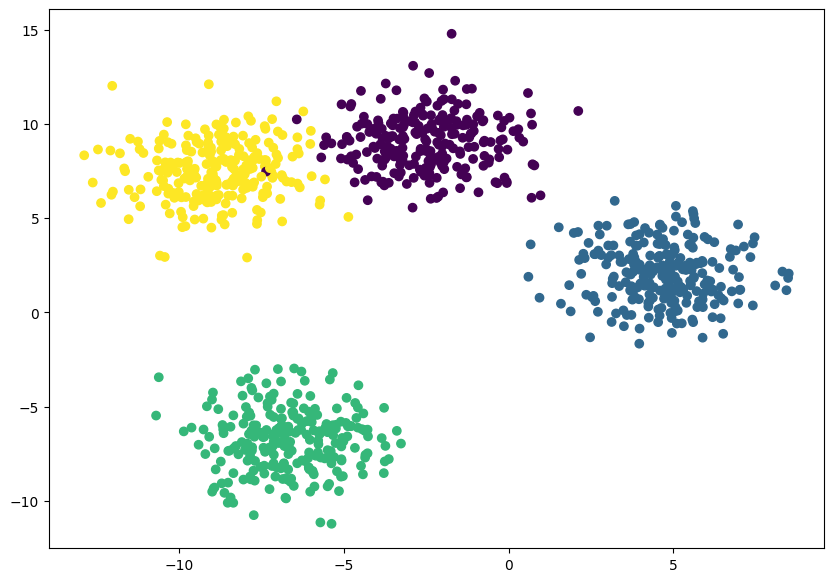

In [1]:
# Import Dependecies
import torch
import requests

from torch import nn
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the Hyperparameter for Data Creation
NUM_SAMPLES = 1000
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create a Multi-Class Data
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn Data to Tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into Train & Test Data
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot Data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)

## 2. Building a Multi-Class Classification Model in PyTorch

In [2]:
# Create a device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
# Build a multi-class classification model
class MultiClassModel(nn.Module):
  def __init__(self, in_feat=2, out_feat=4, hidden_neurons=5):
    """Initializes multi-class classification model.
    
    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.input_layer = nn.Linear(in_features=in_feat, out_features=hidden_neurons)
    self.first_hidden_layer = nn.Linear(in_features=hidden_neurons, out_features=hidden_neurons)
    self.output_layer = nn.Linear(in_features=hidden_neurons, out_features=out_feat)

    ## Set Activation Function
    # self.act_func = nn.ReLU()
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.output_layer(self.first_hidden_layer(self.input_layer(x)))

model = MultiClassModel(in_feat=2, out_feat=4, hidden_neurons=5).to(device)
model

MultiClassModel(
  (input_layer): Linear(in_features=2, out_features=5, bias=True)
  (first_hidden_layer): Linear(in_features=5, out_features=5, bias=True)
  (output_layer): Linear(in_features=5, out_features=4, bias=True)
)

## 3. Create a Loss Function & Optimizer for Multi-Class Classification Model

In [4]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_func = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.Adam(params=model.parameters(), 
                            lr=0.1) # learning rate is a hyperparameter you can change

## 3.1 Import necessary evaluation functions

In [5]:
# Download helper functions
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/UygarKAYA/DeepLearning/main/helper_functions.py?token=GHSAT0AAAAAAB4RI7LGXFBZJSVMSQPKPC5GZCBXJKQ")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


## 4. Creating a Training Loop and Testing Loop for a Multi-Class PyTorch Model

In [6]:
from helper_functions import accuracy_func, precision_recall_f1Score, confusion_matrix_and_classification_report

torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100

# Loop through data
for epoch in range(epochs):
  # Training Mode
  model.train()

  train_logits = model.forward(X_train)
  train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

  train_loss = loss_func(train_logits, y_train)
  train_acc = accuracy_func(train_preds, y_train)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  # Testing Mode
  model.eval()
  with torch.inference_mode():
    test_logits = model.forward(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_func(test_logits, y_test)
    test_acc = accuracy_func(test_preds, y_test)
    precision, recall, f1Score = precision_recall_f1Score(test_preds, y_test)

    if epoch == epochs-1:
      confusion_matrix, classification_report = confusion_matrix_and_classification_report(test_preds, y_test)
      print(f"\n{confusion_matrix}")
      print(f"\n{classification_report}")
  
  # Print out what's happening'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Accuracy: {train_acc:.2f} | Train Loss: {train_loss:.2f} | Test Accuracy: {test_acc:.2f} | Test Loss: {test_loss:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1Score:.2f}")

Epoch: 0 | Train Accuracy: 0.00 | Train Loss: 3.26 | Test Accuracy: 35.00 | Test Loss: 1.25 | Precision: 0.37 | Recall: 0.35 | F1 Score: 0.30
Epoch: 10 | Train Accuracy: 96.25 | Train Loss: 0.11 | Test Accuracy: 98.50 | Test Loss: 0.03 | Precision: 0.99 | Recall: 0.98 | F1 Score: 0.98
Epoch: 20 | Train Accuracy: 99.12 | Train Loss: 0.04 | Test Accuracy: 99.00 | Test Loss: 0.04 | Precision: 0.99 | Recall: 0.99 | F1 Score: 0.99


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 30 | Train Accuracy: 99.38 | Train Loss: 0.04 | Test Accuracy: 99.50 | Test Loss: 0.02 | Precision: 1.00 | Recall: 0.99 | F1 Score: 1.00
Epoch: 40 | Train Accuracy: 99.38 | Train Loss: 0.03 | Test Accuracy: 99.50 | Test Loss: 0.01 | Precision: 1.00 | Recall: 0.99 | F1 Score: 1.00
Epoch: 50 | Train Accuracy: 99.38 | Train Loss: 0.03 | Test Accuracy: 99.50 | Test Loss: 0.01 | Precision: 1.00 | Recall: 0.99 | F1 Score: 1.00
Epoch: 60 | Train Accuracy: 99.38 | Train Loss: 0.02 | Test Accuracy: 99.50 | Test Loss: 0.01 | Precision: 1.00 | Recall: 0.99 | F1 Score: 1.00
Epoch: 70 | Train Accuracy: 99.50 | Train Loss: 0.02 | Test Accuracy: 100.00 | Test Loss: 0.01 | Precision: 1.00 | Recall: 1.00 | F1 Score: 1.00
Epoch: 80 | Train Accuracy: 99.50 | Train Loss: 0.02 | Test Accuracy: 100.00 | Test Loss: 0.01 | Precision: 1.00 | Recall: 1.00 | F1 Score: 1.00
Epoch: 90 | Train Accuracy: 99.50 | Train Loss: 0.02 | Test Accuracy: 100.00 | Test Loss: 0.01 | Precision: 1.00 | Recall: 1.00 | F1 S

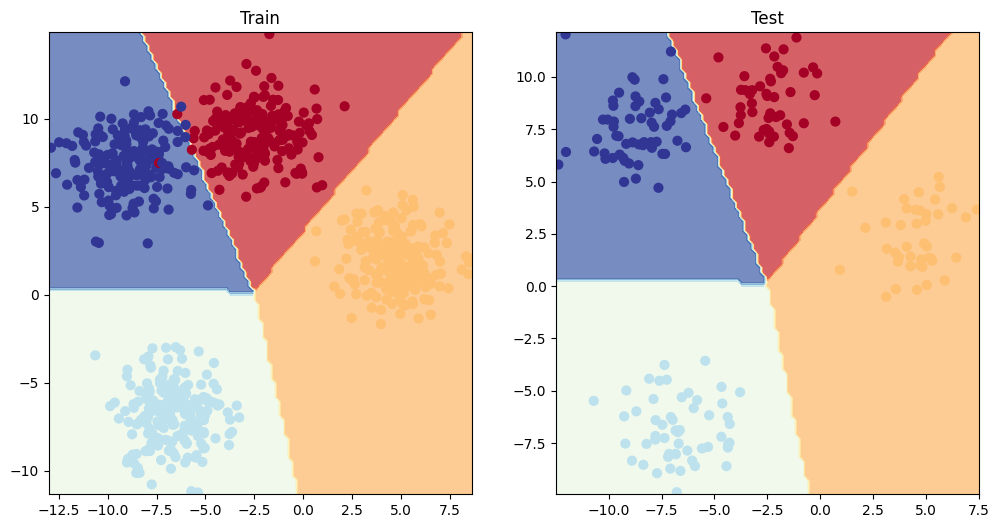

In [7]:
from helper_functions import plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test) 